In [2]:
import sys
import numpy as np
np.random.seed(0)
import torch
import pylab
from sklearn.metrics import confusion_matrix
import itertools
from debug_visualisation import plot_confusion_matrix

# Main code for Concrete Dropout

In [3]:
import keras.backend as K
from keras import initializers
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Wrapper, Concatenate


class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers, not just `Dense`,
    for instance with a `Conv2D` layer:
    ```python
        model = Sequential()
        model.add(ConcreteDropout(Conv2D(64, (3, 3)),
                                  input_shape=(299, 299, 3)))
    ```
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        input_dim = np.prod(input_shape[1:])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

Using Theano backend.


### Plot function to make sure stuff makes sense:

In [4]:
def plot(reps=None,train_loss=None,valid_loss=None,uncertainty=None,val_acc=None, valid_y=None,preds=None):
    
   fig = pylab.figure() 
   _, (ax1, ax2) = pylab.subplots(1, 2,figsize=(15, 5), sharex=False, sharey=False)
   #Plot loss on training and validation set    
   ax1.plot(reps, train_loss, c='r', label='Training')
   ax1.plot(reps, valid_loss, c='g', label='Validation')
   ax1.set_title('Losses')
   ax1.legend()
   #Plot student confusion matrix
   names = ['Slight-Right-Turn','Sharp-Right-Turn','Move-Forward','Slight-Left-Turn']
   cnf_matrix = confusion_matrix(np.argmax(valid_y,axis=-1), preds)  
   pylab.sca(ax2)
   plot_confusion_matrix(cnf_matrix, classes=names,normalize=False,title='Student confusion matrix')
 
   pylab.show()

# Evaluate Concrete Dropout

In [5]:
nb_epochs = [200]
nb_reps = 30
K_test = 50
batch_size = 128
Q = 24
nb_features = 7
l = 1e-6
D = 4
with open('/home/yannis/Desktop/compress_bnn/data/Wall/usableData/valid_data_24sensors_70pc.pt','rb') as f:
      valid = torch.load(f)
with open('/home/yannis/Desktop/compress_bnn/data/Wall/usableData/train_data_24sensors.pt','rb') as f:
      train = torch.load(f)

     
N = train.shape[0]
X_tr = train[:,0:24]
Y_tr = train[:,24:28]
X_v = valid[:,0:24]
Y_v = valid[:,24:28]




o = np.zeros((len(Y_tr), 4))
o[np.arange(len(Y_tr)), Y_tr.flatten().astype(int)] = 1   
Y_tr = o
 

### Fit function:

In [6]:
from keras.layers import Input, Dense, Lambda, merge
from keras.models import Model
from keras import backend as K

def fit_model(nb_epoch, X, Y, validation_data=None):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp = Input(shape=(Q,))
    x = inp
    """
    x = ConcreteDropout(Dense(nb_features, activation='relu',name='CD1'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    #x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(D,activation='sigmoid',name='CD2'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    """
    x = ConcreteDropout(Dense(64, activation='relu',name='CD1'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(32, activation='relu',name='CD1b'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(8, activation='relu',name='CD1c'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = Dense(D,activation='softmax',name='CD2')(x)
    
    out = x 
    model = Model(inp, out)
    
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
    assert len(model.losses) == 3  # a loss for each Concrete Dropout layer
    if validation_data==None:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0)    
    else:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0, validation_data=validation_data)
    loss = hist.history['loss'][-1]
    return hist,model, -0.5 * loss  # return ELBO up to const.

### Eval function:

In [7]:
def test(Y_true, MC_samples):
    """
    :Y_true: a 2D array of size N x 4
    :MC_samples: a 3D array of size samples K x N x 4
    """
    assert len(MC_samples.shape) == 3
    assert len(Y_true.shape) == 2
    k = MC_samples.shape[0]
    N = Y_true.shape[0]
    #Get probability of each class after MC sampling, so that we can get the mean
    
    MC_means = np.sum(MC_samples,axis=0)/float(k)
    MC_pred = np.argmax(MC_means,axis=-1)   
    y_pred = np.argmax(Y_true,axis=-1)
    acc = len(np.where(MC_pred==y_pred)[0])/float(N)*100
    print("\n ( Micro Averaging ) Accuracy: {}".format(acc))

    #For variation ratio
    predictions_per_test_point = np.argmax(MC_samples,axis=-1)
    mode_fx = []
    MC_majVote = np.zeros(MC_pred.shape)
    for i in xrange(N):
        votes, values = np.unique(predictions_per_test_point[:,i], return_counts=True)
        m = np.argmax(votes)
        mode_fx.append((m,values[m]))
        MC_majVote[i] = m
    acc2 = len(np.where(MC_majVote==y_pred)[0])/float(N)*100
    print("\n ( Macro Averaging ) Accuracy: {}".format(acc))
    
    
        
    return acc, acc2, MC_means, MC_pred, mode_fx

        

#Run experiment


 ( Micro Averaging ) Accuracy: 92.005242464

 ( Macro Averaging ) Accuracy: 92.005242464
0.15030144167758847
0.14546483591062212
0.027336940540398702
Confusion matrix, without normalization
[[112   3  14   0]
 [  0 265  14   0]
 [  8  17 285   1]
 [  0   0   4  40]]


<Figure size 432x288 with 0 Axes>

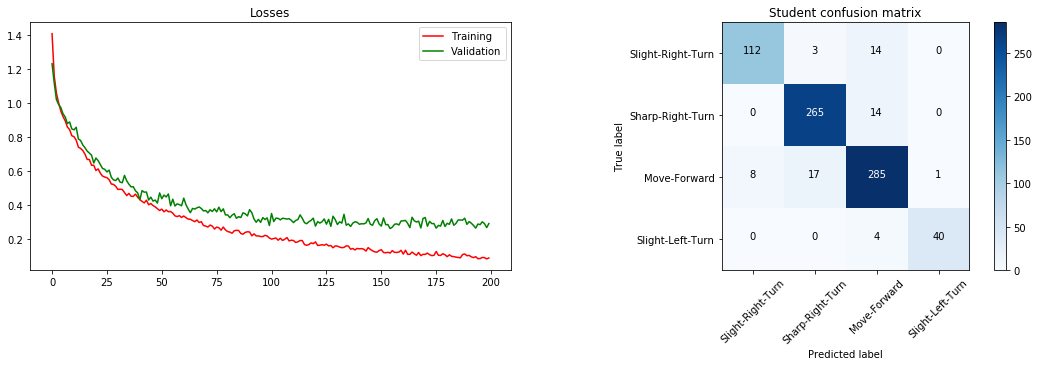


 ( Micro Averaging ) Accuracy: 92.3984272608

 ( Macro Averaging ) Accuracy: 92.3984272608
0.1488597640891219
0.15198829820865417
0.02950089880867056
Confusion matrix, without normalization
[[107   4  18   0]
 [  0 264  14   1]
 [  5  11 292   3]
 [  0   0   2  42]]


<Figure size 432x288 with 0 Axes>

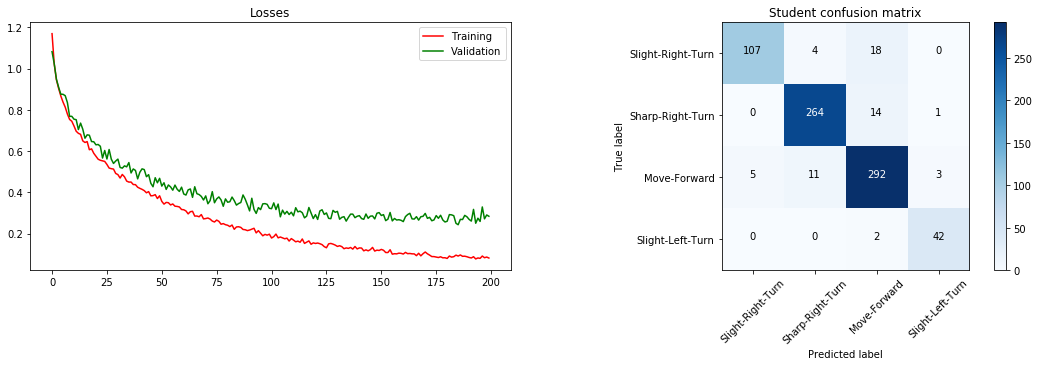


 ( Micro Averaging ) Accuracy: 92.1363040629

 ( Macro Averaging ) Accuracy: 92.1363040629
0.15824377457404978
0.15663030981861278
0.028795754768901533
Confusion matrix, without normalization
[[120   6   3   0]
 [  1 264  13   1]
 [ 10  19 278   4]
 [  0   1   2  41]]


<Figure size 432x288 with 0 Axes>

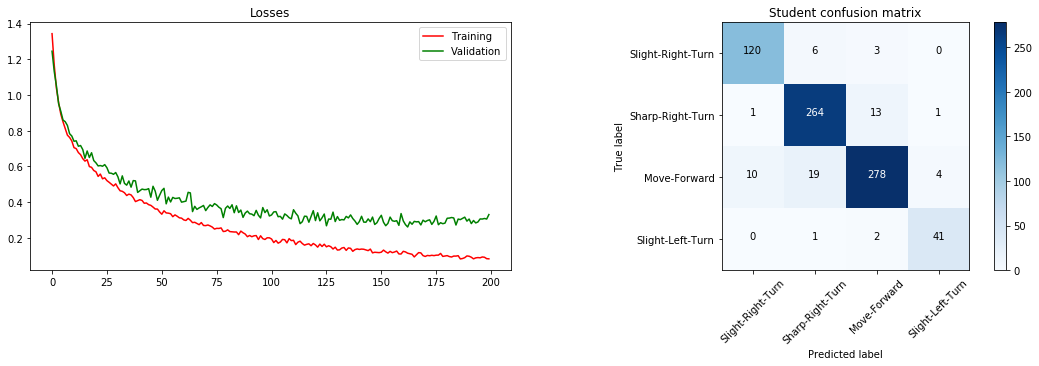


 ( Micro Averaging ) Accuracy: 92.5294888598

 ( Macro Averaging ) Accuracy: 92.5294888598
0.1634862385321101
0.15920233570263864
0.034038718687284975
Confusion matrix, without normalization
[[115   6   8   0]
 [  1 260  15   3]
 [ 10  10 289   2]
 [  0   0   2  42]]


<Figure size 432x288 with 0 Axes>

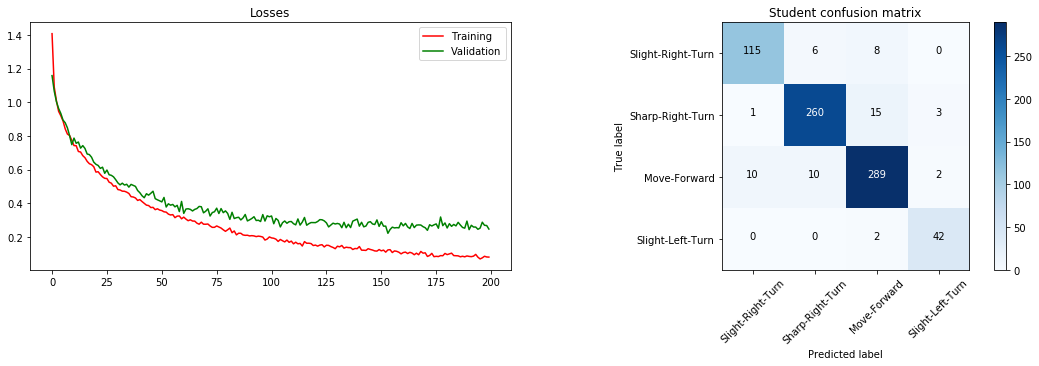


 ( Micro Averaging ) Accuracy: 93.4469200524

 ( Macro Averaging ) Accuracy: 93.4469200524
0.19449541284403668
0.15775766035207445
0.03463399144643879
Confusion matrix, without normalization
[[116   4   9   0]
 [  0 271   8   0]
 [ 10  16 283   2]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

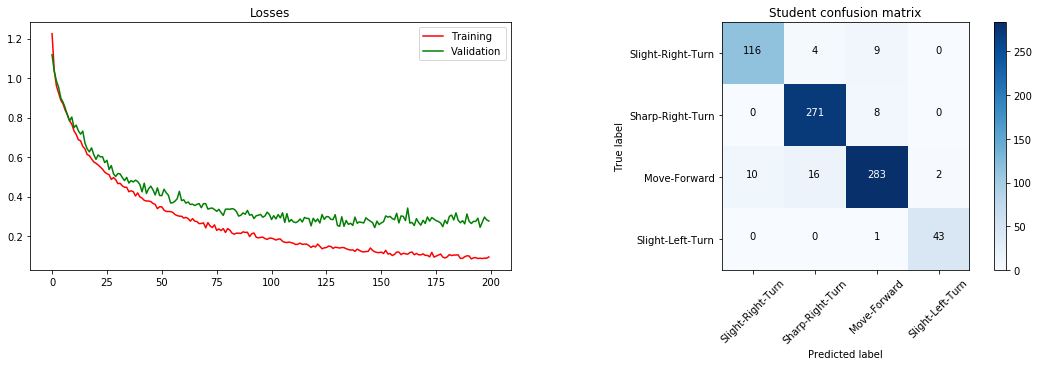


 ( Micro Averaging ) Accuracy: 91.874180865

 ( Macro Averaging ) Accuracy: 91.874180865
0.1567234600262123
0.1596487102783523
0.02753761461490417
Confusion matrix, without normalization
[[113   3  13   0]
 [  2 262  14   1]
 [  8  14 283   6]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

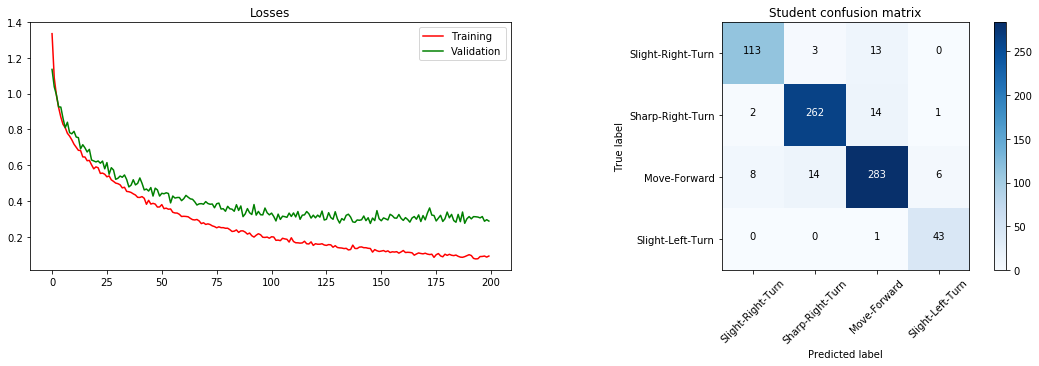


 ( Micro Averaging ) Accuracy: 91.2188728702

 ( Macro Averaging ) Accuracy: 91.2188728702
0.15043250327653998
0.14951755428689179
0.028220980382996794
Confusion matrix, without normalization
[[109   4  16   0]
 [  1 262  15   1]
 [ 10  16 282   3]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

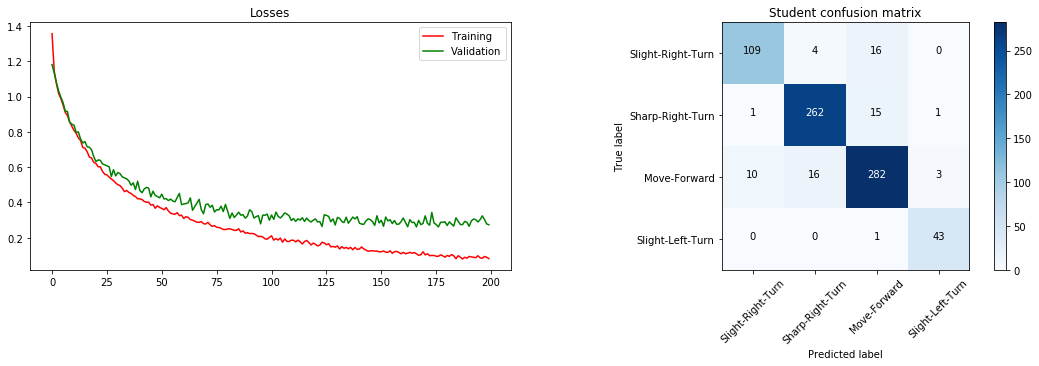


 ( Micro Averaging ) Accuracy: 92.005242464

 ( Macro Averaging ) Accuracy: 92.005242464
0.16269986893840105
0.14744946841018697
0.026581730473869594
Confusion matrix, without normalization
[[113   3  13   0]
 [  1 264  13   1]
 [ 10  14 284   3]
 [  0   0   3  41]]


<Figure size 432x288 with 0 Axes>

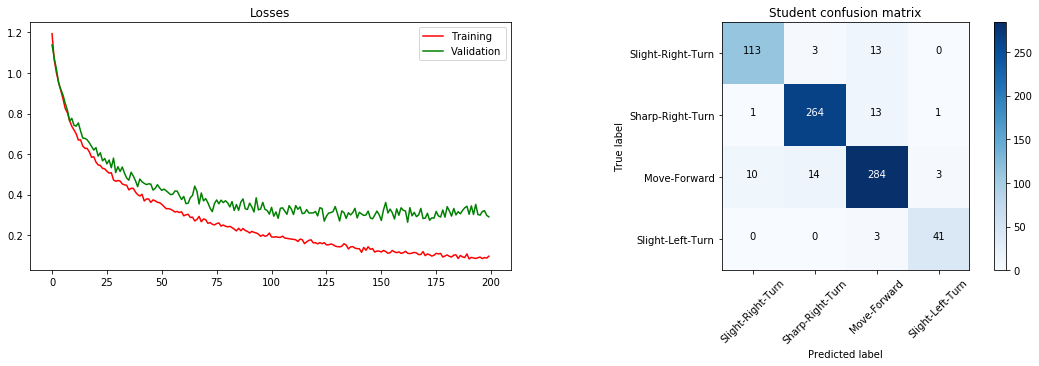


 ( Micro Averaging ) Accuracy: 91.7431192661

 ( Macro Averaging ) Accuracy: 91.7431192661
0.1795281782437746
0.1790404713481938
0.03625271298469754
Confusion matrix, without normalization
[[106   1  22   0]
 [  1 254  21   3]
 [  7   5 297   2]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

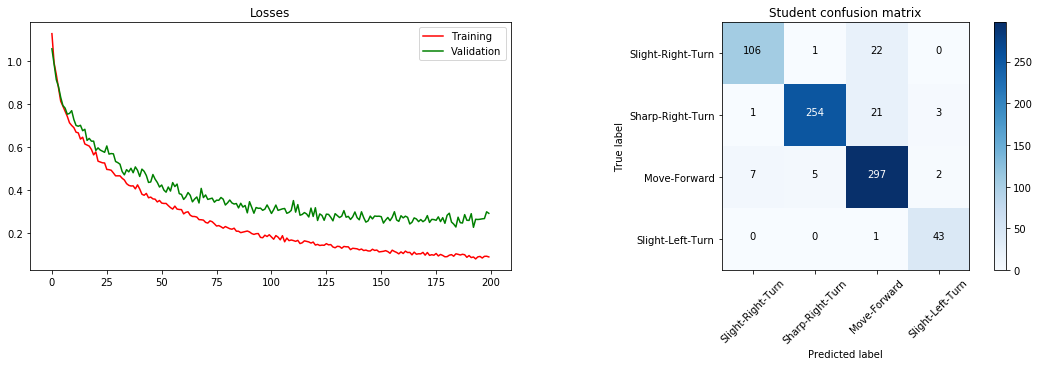


 ( Micro Averaging ) Accuracy: 92.2673656619

 ( Macro Averaging ) Accuracy: 92.2673656619
0.1450065530799476
0.14915387314862694
0.026489767772029618
Confusion matrix, without normalization
[[111   4  14   0]
 [  0 268  10   1]
 [  8  17 282   4]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

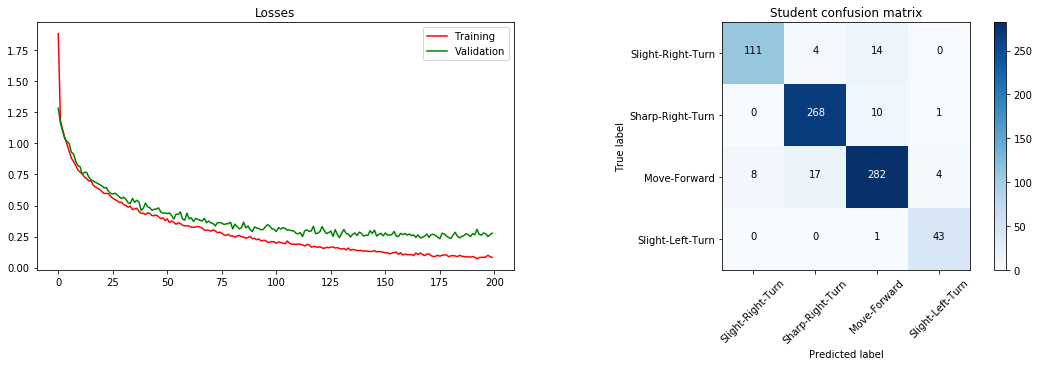


 ( Micro Averaging ) Accuracy: 92.6605504587

 ( Macro Averaging ) Accuracy: 92.6605504587
0.1529488859764089
0.15624526037613656
0.028264476931110755
Confusion matrix, without normalization
[[112   1  16   0]
 [  0 267  11   1]
 [  8  12 286   5]
 [  0   0   2  42]]


<Figure size 432x288 with 0 Axes>

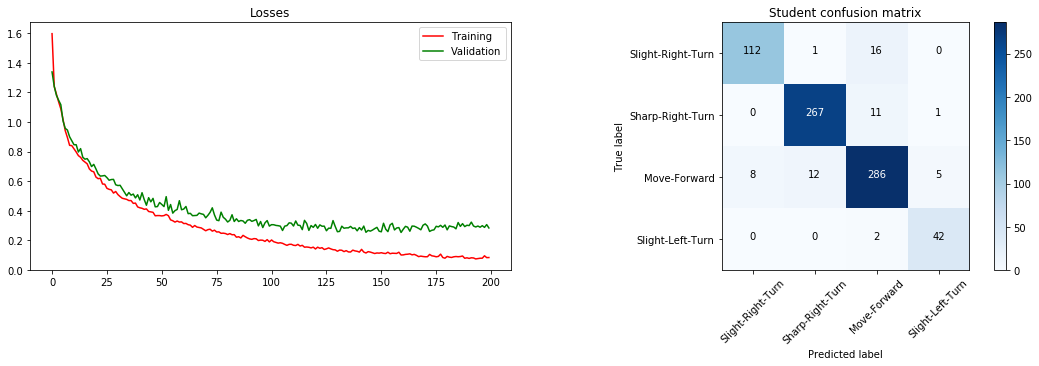


 ( Micro Averaging ) Accuracy: 92.5294888598

 ( Macro Averaging ) Accuracy: 92.5294888598
0.15056356487549147
0.16238888281825956
0.03229576700793027
Confusion matrix, without normalization
[[119   4   6   0]
 [  3 260  13   3]
 [  7  15 285   4]
 [  0   0   2  42]]


<Figure size 432x288 with 0 Axes>

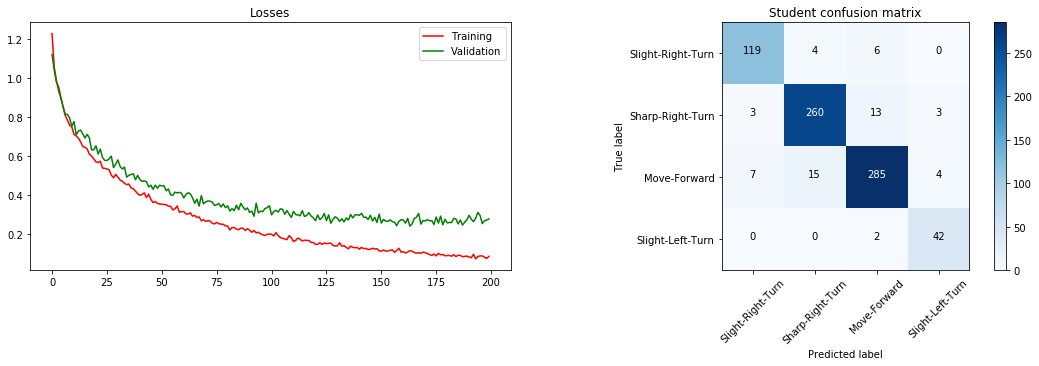


 ( Micro Averaging ) Accuracy: 92.5294888598

 ( Macro Averaging ) Accuracy: 92.5294888598
0.14982961992136304
0.15529186603751127
0.029520227274763472
Confusion matrix, without normalization
[[110   4  15   0]
 [  0 263  15   1]
 [  6  10 292   3]
 [  0   1   2  41]]


<Figure size 432x288 with 0 Axes>

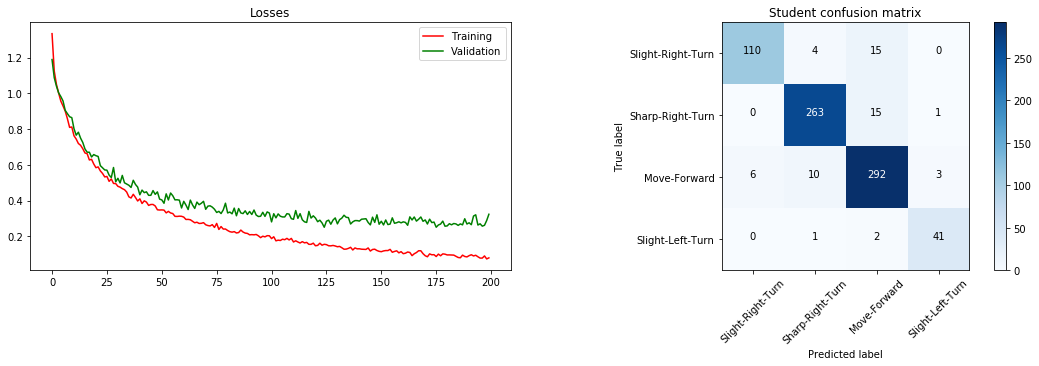


 ( Micro Averaging ) Accuracy: 92.1363040629

 ( Macro Averaging ) Accuracy: 92.1363040629
0.14990825688073395
0.13941540599338037
0.028952972292118906
Confusion matrix, without normalization
[[112   3  14   0]
 [  0 261  17   1]
 [  7  14 287   3]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

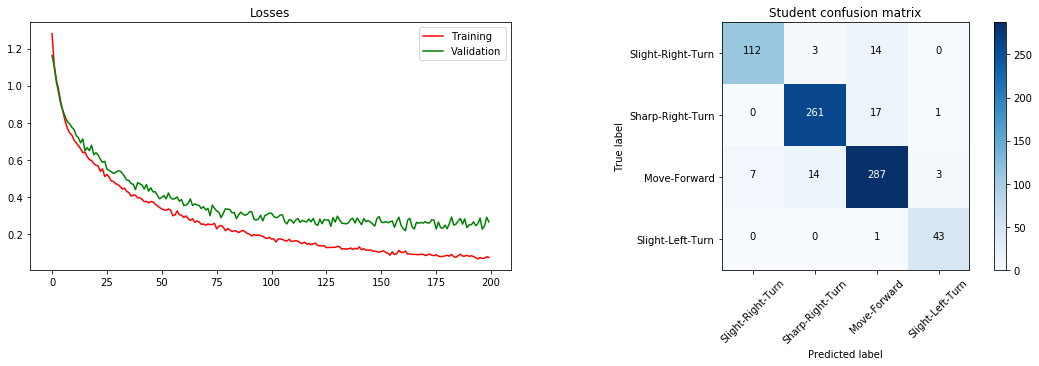


 ( Micro Averaging ) Accuracy: 92.7916120577

 ( Macro Averaging ) Accuracy: 92.7916120577
0.16107470511140237
0.147471196685831
0.03244448520565407
Confusion matrix, without normalization
[[112   6  11   0]
 [  1 267  10   1]
 [  8  14 286   3]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

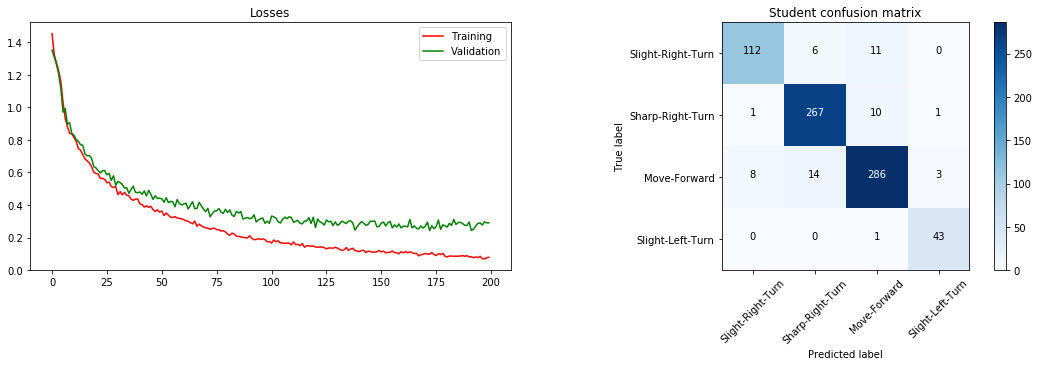


 ( Micro Averaging ) Accuracy: 93.5779816514

 ( Macro Averaging ) Accuracy: 93.5779816514
0.15716906946264744
0.15315379571477208
0.029247368928801823
Confusion matrix, without normalization
[[121   4   4   0]
 [  2 265  11   1]
 [ 12  12 285   2]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

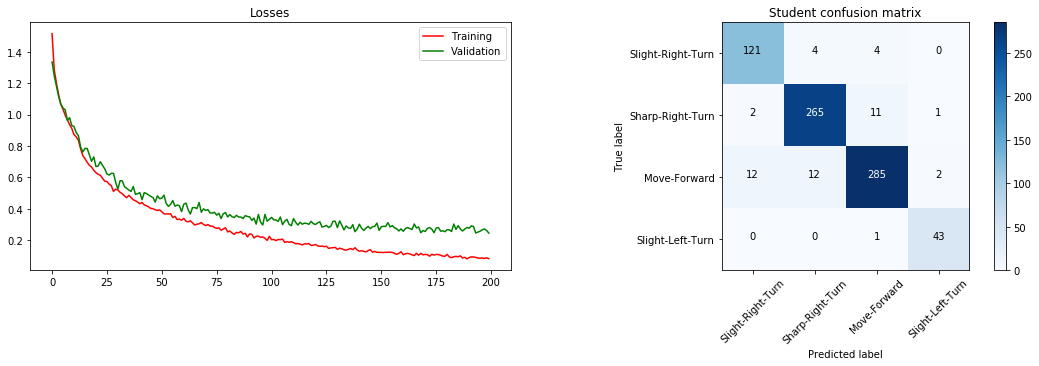


 ( Micro Averaging ) Accuracy: 90.4325032765

 ( Macro Averaging ) Accuracy: 90.4325032765
0.15685452162516383
0.15870864488194217
0.028508487566426738
Confusion matrix, without normalization
[[111   3  15   0]
 [  0 252  24   3]
 [  6  15 286   4]
 [  0   1   2  41]]


<Figure size 432x288 with 0 Axes>

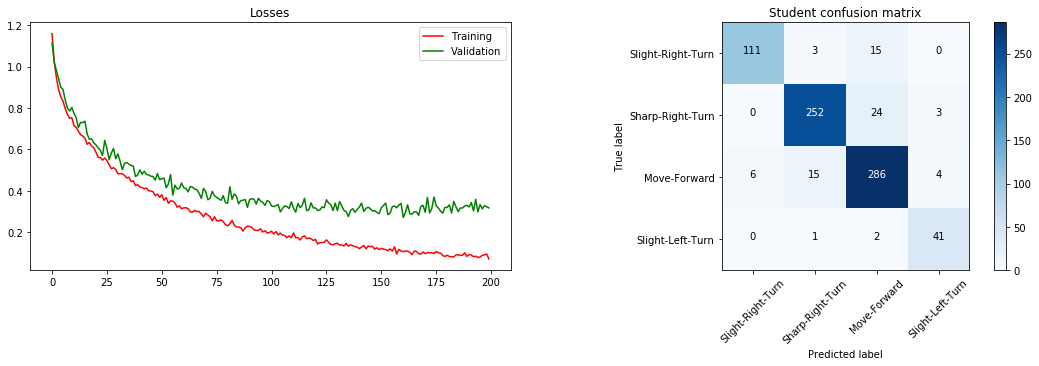


 ( Micro Averaging ) Accuracy: 92.7916120577

 ( Macro Averaging ) Accuracy: 92.7916120577
0.16453473132372215
0.15981542704770949
0.025689431286733067
Confusion matrix, without normalization
[[117   6   6   0]
 [  2 263  12   2]
 [  9  14 286   2]
 [  0   0   2  42]]


<Figure size 432x288 with 0 Axes>

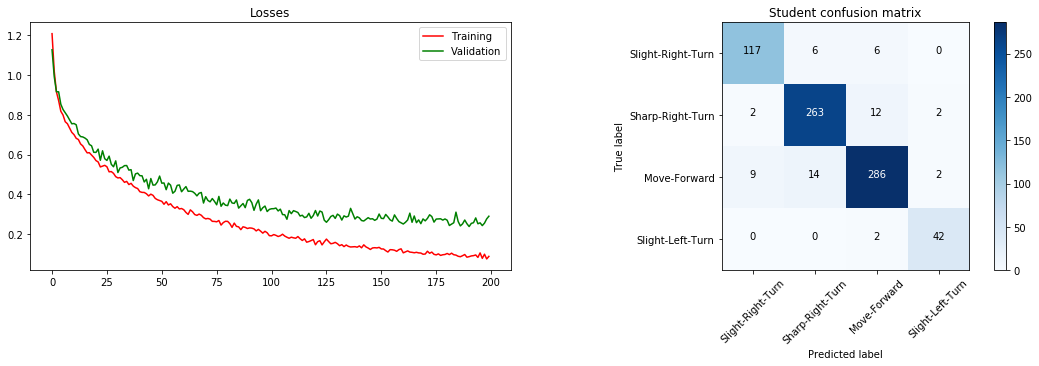


 ( Micro Averaging ) Accuracy: 91.4809960682

 ( Macro Averaging ) Accuracy: 91.4809960682
0.16610747051114025
0.15968594732322042
0.03109400237997112
Confusion matrix, without normalization
[[114   3  12   0]
 [  2 251  22   4]
 [  8  10 290   3]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

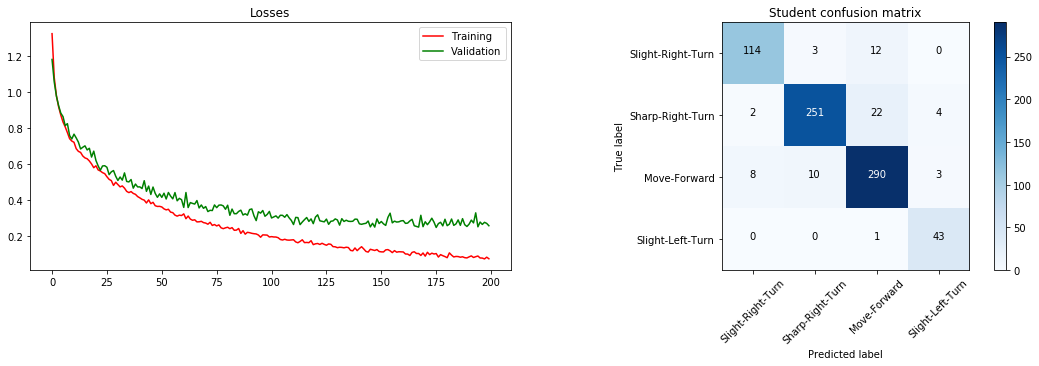


 ( Micro Averaging ) Accuracy: 91.4809960682

 ( Macro Averaging ) Accuracy: 91.4809960682
0.18432503276539972
0.17364081986453556
0.03114858804805251
Confusion matrix, without normalization
[[113   5  11   0]
 [  1 265  10   3]
 [ 13  15 278   5]
 [  0   0   2  42]]


<Figure size 432x288 with 0 Axes>

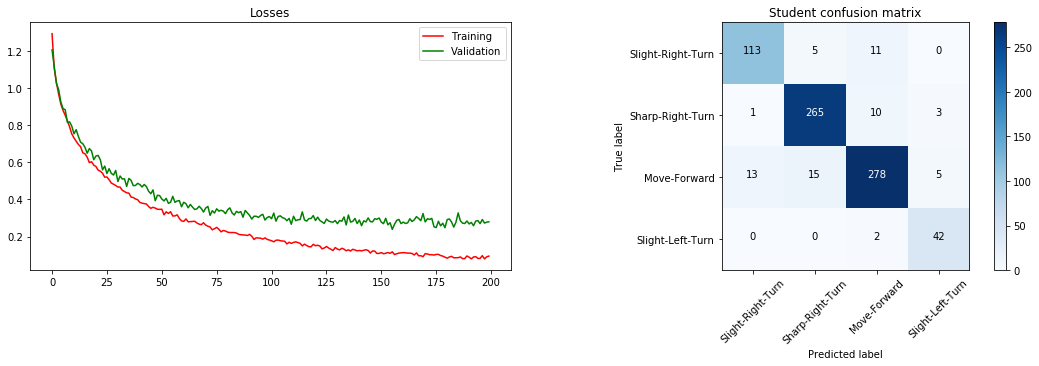


 ( Micro Averaging ) Accuracy: 92.1363040629

 ( Macro Averaging ) Accuracy: 92.1363040629
0.17195281782437744
0.1599144291908994
0.0340059812853252
Confusion matrix, without normalization
[[114   4  11   0]
 [  1 266  11   1]
 [ 10  15 282   4]
 [  0   0   3  41]]


<Figure size 432x288 with 0 Axes>

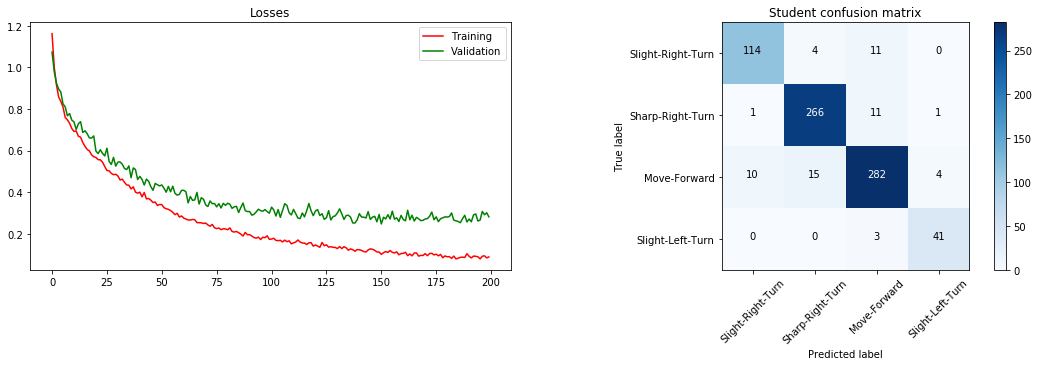


 ( Micro Averaging ) Accuracy: 92.2673656619

 ( Macro Averaging ) Accuracy: 92.2673656619
0.15541284403669725
0.15360228012304944
0.0313458223955347
Confusion matrix, without normalization
[[112   4  13   0]
 [  0 265  13   1]
 [  8  15 285   3]
 [  0   0   2  42]]


<Figure size 432x288 with 0 Axes>

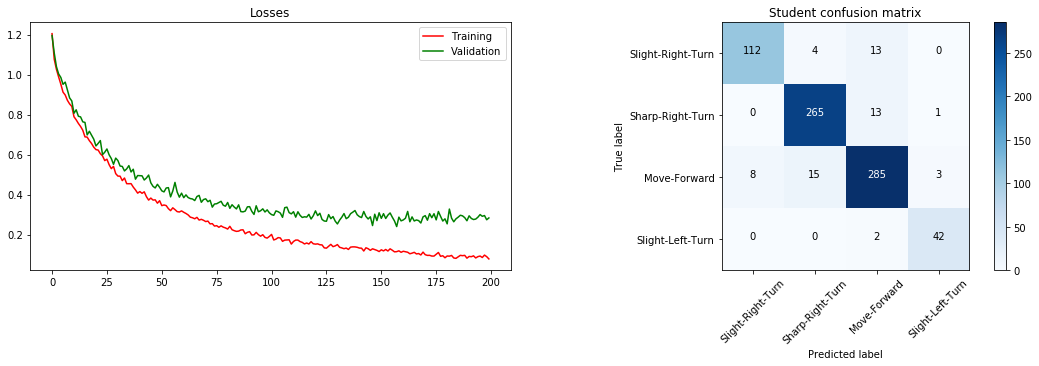


 ( Micro Averaging ) Accuracy: 90.5635648755

 ( Macro Averaging ) Accuracy: 90.5635648755
0.1617038007863696
0.1409306357447473
0.028040874676185698
Confusion matrix, without normalization
[[113   3  13   0]
 [  1 258  18   2]
 [ 10  17 279   5]
 [  0   0   3  41]]


<Figure size 432x288 with 0 Axes>

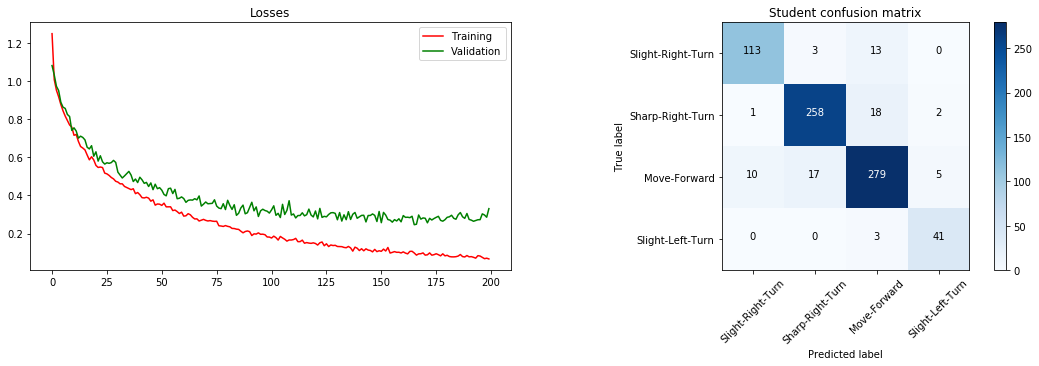


 ( Micro Averaging ) Accuracy: 92.3984272608

 ( Macro Averaging ) Accuracy: 92.3984272608
0.14065530799475753
0.14355070781582774
0.027682423122900965
Confusion matrix, without normalization
[[111   4  14   0]
 [  1 262  15   1]
 [  6  14 289   2]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

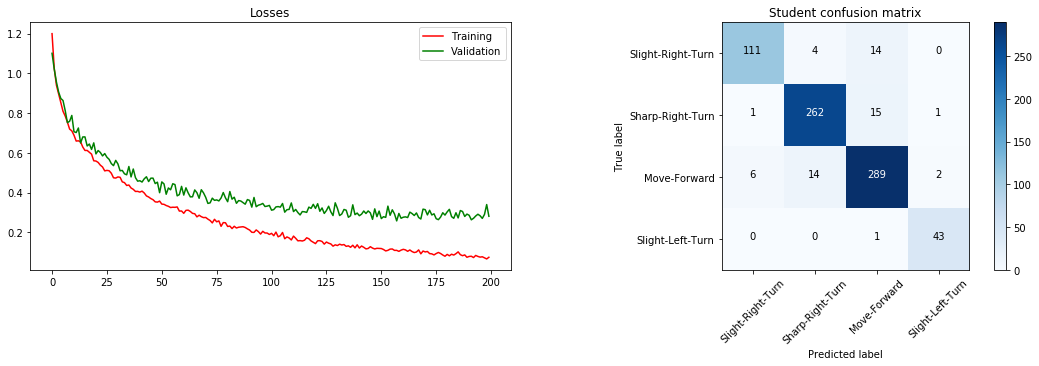


 ( Micro Averaging ) Accuracy: 91.4809960682

 ( Macro Averaging ) Accuracy: 91.4809960682
0.18681520314547836
0.1695471047417677
0.03377235982552426
Confusion matrix, without normalization
[[105   3  21   0]
 [  1 259  15   4]
 [  4  10 292   5]
 [  0   1   1  42]]


<Figure size 432x288 with 0 Axes>

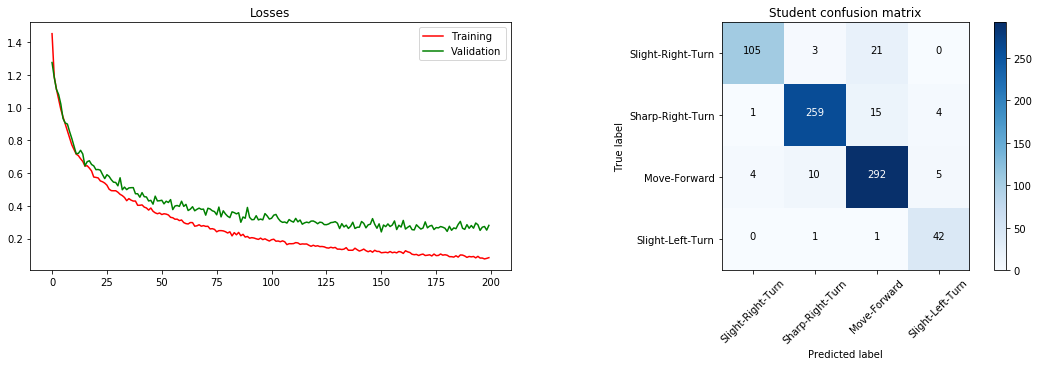


 ( Micro Averaging ) Accuracy: 92.2673656619

 ( Macro Averaging ) Accuracy: 92.2673656619
0.16201834862385323
0.15075370618587708
0.03268315626471882
Confusion matrix, without normalization
[[107   1  21   0]
 [  3 260  15   1]
 [  6   8 294   3]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

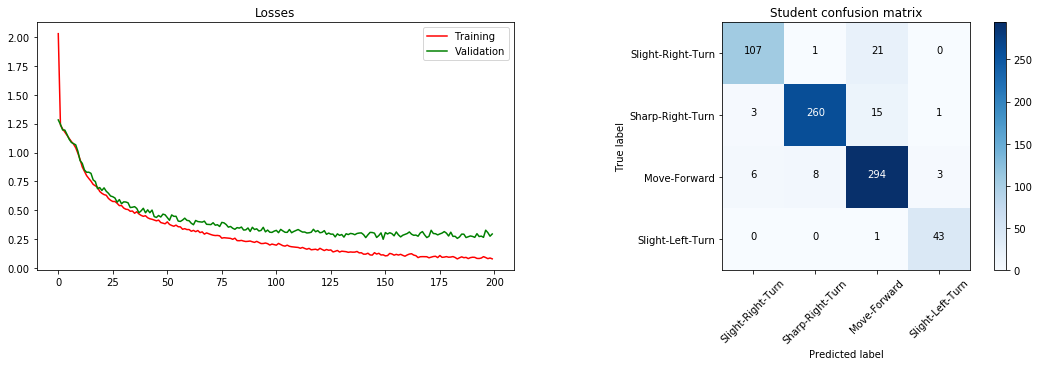


 ( Micro Averaging ) Accuracy: 91.7431192661

 ( Macro Averaging ) Accuracy: 91.7431192661
0.17761467889908258
0.1560175284489423
0.03161346115572268
Confusion matrix, without normalization
[[113   1  15   0]
 [  2 256  20   1]
 [  9   8 290   4]
 [  0   1   2  41]]


<Figure size 432x288 with 0 Axes>

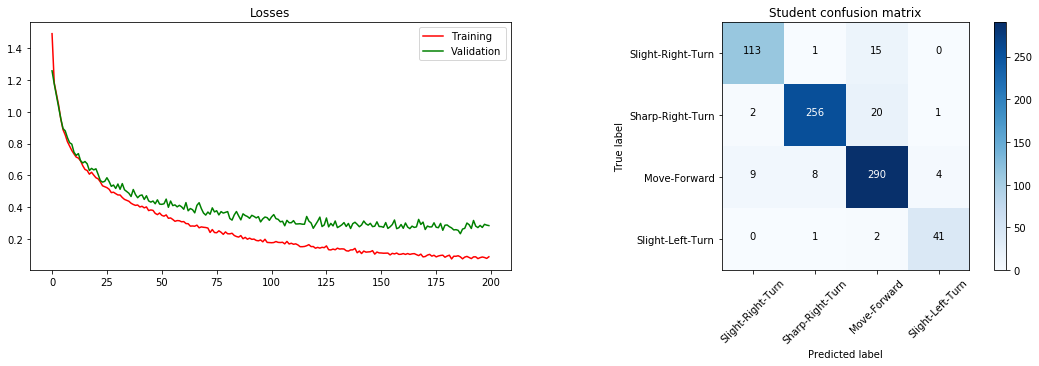


 ( Micro Averaging ) Accuracy: 92.6605504587

 ( Macro Averaging ) Accuracy: 92.6605504587
0.16330275229357796
0.16788735645939137
0.03178934719740639
Confusion matrix, without normalization
[[113   1  15   0]
 [  3 261  14   1]
 [  7  10 292   2]
 [  0   0   3  41]]


<Figure size 432x288 with 0 Axes>

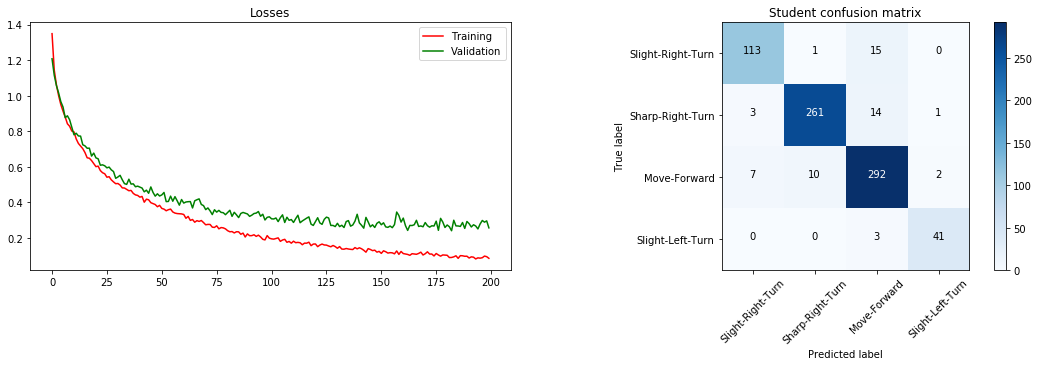


 ( Micro Averaging ) Accuracy: 92.9226736566

 ( Macro Averaging ) Accuracy: 92.9226736566
0.12671035386631718
0.14416310921565265
0.029270717075892863
Confusion matrix, without normalization
[[114   1  14   0]
 [  0 264  12   3]
 [  6  15 288   2]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

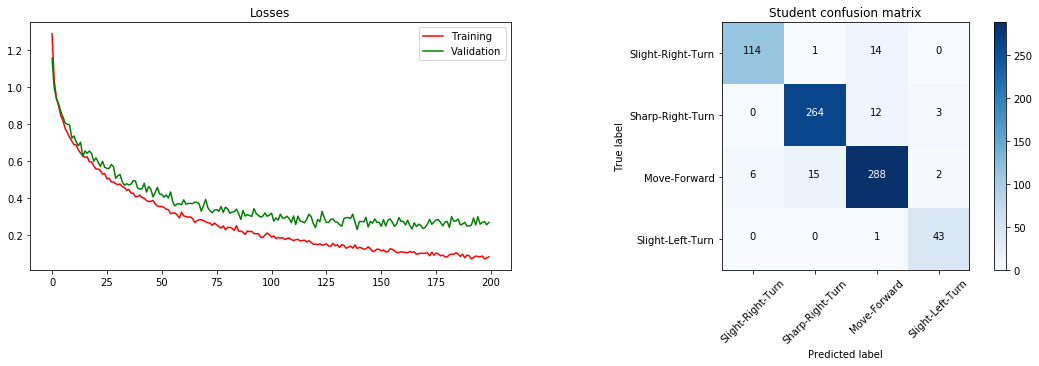


 ( Micro Averaging ) Accuracy: 92.1363040629

 ( Macro Averaging ) Accuracy: 92.1363040629
0.14823066841415464
0.15389696673671976
0.02774845788238245
Confusion matrix, without normalization
[[117   1  11   0]
 [  1 259  18   1]
 [  9  15 284   3]
 [  0   0   1  43]]


<Figure size 432x288 with 0 Axes>

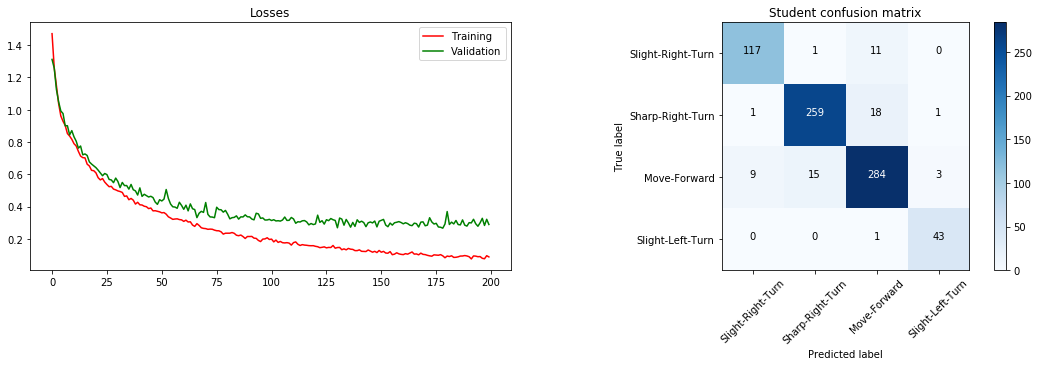

Epoch - Mean accuracy - Accuracy standard deviation - Dropout probabilities per layer   -   Mean Variation ratio  -  Mean Predictive Entropy  -  Mean Mutual Information
200 - 92.15377894276976     0.12642645844893516      [0.00301694 0.00497931 0.00829546]  -  0.15991699432066406  -  0.15539781962903423  -  0.03015025060944497


In [8]:
results = []

# get results for multiple N
#for N, nb_epoch in zip(Ns, nb_epochs):
for nb_epoch in nb_epochs:
       
    # repeat exp multiple times
    rep_results = []
    for i in xrange(nb_reps):
        X_train, Y_train = X_tr, Y_tr
        X_val, Y_val = X_v, Y_v
        hist, model, ELBO = fit_model(nb_epoch, X_train, Y_train, validation_data=(X_val, Y_val))
        valid_loss_hist = hist.history['val_loss']
        train_loss_hist = hist.history['loss']
       
    
        """
        Get uncertainty metrics.
        
        Variation ratio = 1 - majority_class/(total number of samples)
        Predictive entropy = -Sum_c( p(y==c|D)log( p(y==c|D) ) )
        Mutual Information = PredictiveEntropy - E[ PredictiveEntropy ]
        """
        MC_samples = np.array([model.predict(X_val) for _ in range(K_test)])
        acc, acc_maj_vote, MC_means, MC_pred, mode_fx = test(Y_val, MC_samples)  
        
        #Average variation ratio over the minibatch
        variation_ratio = np.zeros(MC_pred.shape)
        for j in xrange(len(MC_pred)):
            variation_ratio[j] = 1 - ((mode_fx[j])[1])/float(K_test)
        variation_ratio_avg_VR = np.sum(variation_ratio)/float(len(MC_pred))
        print(variation_ratio_avg_VR)
       
        #Average predictive entropy over minibatch
        predictive_entropy = -1*np.sum(MC_means*np.log(MC_means),axis=-1)
        predictive_entropy_avg_H = np.sum(predictive_entropy)/float(len(MC_pred))
        print(predictive_entropy_avg_H)
        
        #Average mutual information over minibatch
        expected_entropy = np.sum(np.sum(MC_samples*np.log(MC_samples),axis=-1),axis=0)/float(K_test)
        mutual_nformation_avg_MI = predictive_entropy_avg_H + np.sum(expected_entropy)/float(len(MC_pred))
        print(mutual_nformation_avg_MI)
        
              
        ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
              
        """
        Save best model weights
        """
        if rep_results!=[]:
            if acc>rep_results[-1][0]:
               model.save_weights('/home/yannis/Desktop/compress_bnn/DNN_model/DNN_weights.h5') 
        else:
            model.save_weights('/home/yannis/Desktop/compress_bnn/DNN_model/DNN_weights.h5')

        rep_results += [(acc, acc_maj_vote, ps, variation_ratio_avg_VR, predictive_entropy_avg_H, mutual_nformation_avg_MI )]
        plot(range(nb_epoch),train_loss=train_loss_hist,valid_loss=valid_loss_hist,valid_y=Y_val,preds=MC_pred)
    
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[2] for r in rep_results], 0)
    VR_avg = np.mean([r[3] for r in rep_results])
    H_avg = np.mean([r[4] for r in rep_results])
    MI_avg = np.mean([r[5] for r in rep_results])
    print("Epoch - Mean accuracy - Accuracy standard deviation - Dropout probabilities per layer   -   Mean Variation ratio  -  Mean Predictive Entropy  -  Mean Mutual Information")
    print nb_epoch, '-', test_mean, '   ', test_std_err, '    ',ps, ' - ', VR_avg, ' - ', H_avg, ' - ',MI_avg
    sys.stdout.flush()
    results += [rep_results]
    



In [38]:
#KeplerMapper
from kmapper import jupyter
import kmapper as km
from sklearn import metrics, cluster, preprocessing

predict_penultimate_layer =  K.function([model.layers[0].input, K.learning_phase()], [model.layers[-2].output])
X_inverse_test = np.array(predict_penultimate_layer([X_v, 1]))[0]
print((X_inverse_test.shape, "X_inverse_valid shape"))

X_projected_test = np.c_[variation_ratio, predictive_entropy, predictive_entropy+expected_entropy]
print((X_projected_test.shape, "X_projected_valid shape"))

mapper = km.KeplerMapper(verbose=0)
G = mapper.map(X_projected_test,None,
               #X_inverse_test, CLUSTERING BASED ON UNCERTAINTY
               clusterer=cluster.AgglomerativeClustering(n_clusters=2),
               overlap_perc=0.9,
               nr_cubes=10)

color_function_output = predictive_entropy+expected_entropy

_ = mapper.visualize(G,
                 projected_X=X_projected_test,
                 projected_X_names=["Variation Ratio", "Predictive Entropy", "Mutual Information"],
                 color_function=color_function_output,
                 title="Confidence Graph for an MLP trained on Obstacle Avoidance dataset")

jupyter.display("mapper_visualization_output.html")

((763, 8), 'X_inverse_valid shape')
((763, 3), 'X_projected_valid shape')


In [15]:
import pickle
with open('./concrete-dropout.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
# import pickle
# with open('concrete-dropout.pkl', 'rb') as f:
#     results = pickle.load(f)

In [16]:
best_tests = np.array([[r[0] for r in result] for result in results]).T
best_ps = np.array([[r[1] for r in result] for result in results])
best_epistemic_uncertainty = np.array([[r[2] for r in result] for result in results]).T.squeeze()
print best_tests.mean(0)
print best_ps.mean(1)

[93.25688073]
[[1.8591734e-04 7.4411029e-05]]


In [ ]:
import pylab
%matplotlib inline

pylab.figure(figsize=(3, 3))
pylab.plot(N, np.mean(best_epistemic_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Epistemic uncertainty (std)')
pylab.xscale('log')
pylab.savefig('epistemic.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
predictive = np.mean(best_epistemic_uncertainty, 0) + np.mean(best_aleatoric_uncertainty, 0)
pylab.plot(N, predictive**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Predictive uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('predictive.pdf', bbox_inches='tight')
pylab.show()

In [ ]:
pylab.figure(figsize=(3, 1.5))
ps = best_ps.mean(1)
ps_std = best_ps.std(1)
for i, (p, p_std) in enumerate(zip(ps.T, ps_std.T)):
    if i == 4:
        continue  # layer 4 is noise layer
    pylab.plot(N, p, '-*', label='Layer #' + str(i+1))
#     pylab.fill_between(Ns, p + p_std, p - p_std, alpha=0.25)
pylab.legend(bbox_to_anchor=(1, 0), loc='lower left')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Dropout probability')
pylab.xscale('log')
pylab.savefig('dropout_prob.pdf', bbox_inches='tight')
pylab.show()